# 0 Before starting simulations

**This step is optional!**

ParticleTrajectorySimulationsCore can take advantage of thread-parallelism. To activate the feature, one needs to start julia with specifying the available number of threads. Check the document.

https://docs.julialang.org/en/v1/manual/multi-threading/

# 1 Load ParticleTrajectorySimulationsCore module

```julia
using ParticleTrajectorySimulationsCore
```

# 2 Make an apparatus model
The first step is to make an model of an apparatus. An apparatus in the simulation is consists of a nozzle and a sequence of objects; slit, obstacle and electrodes.

## 2.1 Choose a nozzle
Nozzle is the equipment to emit molecule into vacuum, which is then understood as a generator of initial parameters of trajectories.
It determines the total number of trajectories to run and those initial parameters.
Currently, three kinds of nozzles are implemented; `FunctionNozzle`, `IteratorNozzle`, and `RandomPointNozzle`.


### 2.1.1 IteratorNozzle
To constract a `IteratorNozzle`, an iteratable object of initial parameters; initial time (1 item), initial coordinates (3 items), and initial velocity (3 items), in this order.

The following example emits 101 particles into different angles in z-y plane with the fixed velocity.

```julia
# Fix the initial time at zero
t0 = 0.0
# Fix the initial position at the origin
x0, y0, z0 = 0.0, 0.0, 0.0
# Norm of the velocity vector [m/s]
v0 = 500.0

iter = []
for θ in -5:0.1:5
    push!(iter, [t0, x0, y0, z0, 0.0, v0*sind(θ), v0*cosd(θ)])
end
nozzle = IteratorNozzle(iter)
```

### 2.1.2 RandomPointNozzle
This is a nozzle to emit particles randomly from a certain point. Its constructor takes 5 arguments.

```julia
RandomPointNozzle(coordinates, orientation, n::Integer, vmin::Real,
                  vmax::Real, theta::Real; rng=default_rng())
```

- `coordinates` is an iterable with 3 items representing the point particles are emitted in (x, y, z) order.
- `orientation` is an iterable with 3 items representing the orientation of the nozzle. It is written as a set of Euler angles in ZYZ manner, and the nozzle is oriented toward z-axis if (0, 0, 0) is given.
- `n` is the number of particle to be generated.
- A particle speed is uniformly sampled from the range \[`vmin`, `vmax`\].
- `theta` is a half apex angle of cone to emit particles.

```julia
x0, y0, z0 = 0.0, 0.0, 0.0
α, β, χ = 0.0, 0.0, 0.0
n = 500
vmin = 470.0
vmax = 530.0
θ = 5.0
nozzle = RandomPointNozzle((x0, y0, z0), (α, β, χ), n, vmin, vmax, θ)
```

### 2.1.3 FunctionNozzle
To constract a `FunctionNozzle`, a function that takes 3 arguments is required; `u`, `i`, and `particle`.
- `u` is a vector of parameters with 7 items. Those are initial time (1 item), initial coordinates (3 items), and initial velocity (3 items), in this order. The function should modify the array directly to give a set of initial parameters.
- `i` is the current number of trajectories, it starts from 1 and incremented with trajectories.
- `particle` is an instance belonging to `AbstractParticle` which contains the information of molecule.

The use of `i` and `particle` are optional.
The function should return `true` to continue the simulation or return `false` to quit.
The following example emits 500 particles into different angles in z-y plane with the fixed velocity.

```julia
# Define a function
function nozzlefunction!(u, i, particle)
    n = 500
    i > n && return false

    # Fix the initial time at zero
    t0 = 0.0
    # Fix the initial position at the origin
    x0, y0, z0 = 0.0, 0.0, 0.0
    # Norm of the velocity vector [m/s]
    v0 = 500.0

    θi = -5
    θf =  5
    θ = θi + (i - 1)*(θf - θi)/n
    u[1] = t0
    u[2] = x0
    u[3] = y0
    u[4] = z0
    u[5] = 0.0
    u[6] = v0*sind(θ)
    u[7] = v0*cosd(θ)
    return true
end

# Construct a FunctionNozzle
nozzle = FunctionNozzle(nozzlefunction!)
```

## 2.2 Build an apparatus
A model of apparatus is constructed as an instance of `SimpleApparatus` with a nozzle and an array of `Instrument`s.

```julia
apparatus = SimpleApparatus(
    RandomPointNozzle((0.0, 0.0, 0.0), (0.0, 0.0, 0.0), 500, 470.0, 530.0, 5.0),
    Instrument[
        CircularSlit((0.0, 0.0, 0.5), (0, 0, 0), 0.0005),
        CircularSlit((0.0, 0.0, 1.0), (0, 0, 0), 0.0005),
        Deflector((0.0, 0.0, 1.5), (0, 0, 0), 0.3, 10000., 0.0017, (1.0, -0.2, 0.0), 10000.0, -10000.0),
        CircularSlit((0.0, 0.0, 2.8), (0, 0, 0), 0.05),
    ])
```

Currently, the following instruments are implemented.

- Skimmer
- CircularObstacle
- CircularSlit
- RectangularSlit
- Hexapole
- Deflector

Particles pass through those instruments otherwise blocked.
Each instrument is always constructed with `coordinates` and `orientation` which represents the location and the orientation in the 3D space.
`coordinates` is an iterable with 3 items representing the point particles are emitted in (x, y, z) order.
`orientation` is an iterable with 3 items representing the orientation of the nozzle.
It is written as a set of Euler angles (α, β, γ) in ZYZ manner, and the nozzle is oriented toward z-axis if (0, 0, 0) is given.
Each instrument should have one or more additional arguments to characterize itself.
Type `?{Instrument name}<Enter>` in Julia REPL for more information, for example `?CircularSlit`.
Particles should pass through the instruments one-by-one and in the order of the array.

# 3 Define a particle

The next step is to define a particle to be simulated.
 Currently, `BasicSymmetricTop` is implemented.

```julia
# Name of the particle
# NOTE: It doesn't affect the simulation. Just a label.
name = "methyl iodide"
# Mass in atomic unit
mass = 141.94
# Rotational constant around the principal axis in cm-1.
rot = 0.25
# Permanent dipole moment along the principle axis in debye.
dip = 1.6406
# Rotational quantum numbers
J = 1
K = -1
M = 1
p = BasicSymmetricTop(name, mass, rot, dip, J, K, M)
```

It is also possible to define a new molecule.
To define a new molecule `p`, make a new type for the molecule as a subtype of `AbstractParticle` first.
Next, two methods `mass(p)` and `effective_dipole(p, E)` should be implemented for `p`.

`mass(p)` should return its mass in *kg* unit.

`effective_dipole(p, E)` should return the first derivative of the Stark energy with respect to the electric field strength `E` in SI unit system, that is, $-\frac{\partial{W_{stark}}}{\partial{E}}$ .

For example, define a simple CO molecule (J = 6, MΩ = 6, Ω = 1) used in [A. J. de Nijs and H. L. Bethrem](http://xlink.rsc.org/?DOI=c1cp21477b).
Here, the effective dipole is constant since only the first order Stark may taken into account.

```julia
struct CO <: AbstractParticle end
ParticleTrajectorySimulationsCore.mass(::CO) = 28e-3/NA
ParticleTrajectorySimulationsCore.effective_dipole(::CO, E) = -0.2*3.33564e-30
```

# 4 Determine the output file path

The result of a simulation is saved as a file in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/).
User should give a valid path to the output file for a simulation.

```julia
outputfile = "result.h5"
```

# 5 Run a simulation

```julia
ParticleTrajectorySimulationsCore.run(apparatus, p, log=outputfile)
```

Let's run a simulation!

In [1]:
# Load the module
using ParticleTrajectorySimulationsCore

# This is not needed for real use (This is to fix pseudo-rangom number series)
using Random: Xoshiro
rng = Xoshiro(12345)

# Make a nozzle with 5 particles
# The part "; rng=rng" is NOT needed for real use
n = 5
nozzle = RandomPointNozzle((0.0, 0.0, 0.0), (0, 0, 0), n, 470, 530, 0.06; rng=rng)

# Make an apparatus model
apparatus = SimpleApparatus(
    nozzle,
    Instrument[
        CircularSlit((0.0, 0.0, 0.5), (0, 0, 0), 0.0005),
        CircularSlit((0.0, 0.0, 1.0), (0, 0, 0), 0.0005),
        Deflector((0.0, 0.0, 1.5), (0, 0, 0), 0.3, 1.0e-3, (1.2000318221585364, 0.4095783620016407, 9.626655484494e-06), 5000.0, 0.0),
        CircularSlit((0.0, 0.0, 2.8), (0, 0, 0), 0.05),
    ])

# Make a molecule
p = BasicSymmetricTop("methyl iodide", 141.94, 0.25, 1.6406, 1, 1, -1)

# Specify the output file path
outputfile = "result.h5"

# Run a simulation
ParticleTrajectorySimulationsCore.run(apparatus, p, log=outputfile)

# 6 Readout the results

The result will be written in [HDF5 format](https://www.hdfgroup.org/solutions/hdf5/); therefore, it can be read by another programs other than julia, for example, python with h5py package.

It is still OK if one doesn't know anything about HDF5. ParticleTrajectorySimulationsCore module provides several handy interfaces to the output files to read results.

## 6.1 Handy interfaces

### Index
- [number_of_trajectories](#6.1.1-number_of_trajectories)
    - Return the number of trajectories recorded in a file.
- [number_of_recorded_points](#6.1.2-number_of_recorded_points)
    - Return the number of recorded points (coordinates) of a trajectory
- [collect_success_attribute](#6.1.3-collect_success_attribute)
    - Return a BitVector which element is true if corresponding trajectory got succeeded otherwise false.
- [collect_initial_points](#6.1.4-collect_initial_points)
    - Return an Matrix of the first coordinates of each trajectory.
- [collect_end_points](#6.1.5-collect_end_points)
    - Return an Matrix of the last coordinates of each trajectory.
- [collect_trajectories](#6.1.6-collect_trajectories)
    - Return an Vector of trajectories as a Matrix.

---

### 6.1.1 number_of_trajectories
```julia
out = number_of_trajectories(file)::Int
out = number_of_trajectories(file::HDF5.File)::Int
```
Return the number of trajectories recorded in an output file of ParticleTrajectorySimulationsCore.

#### Parameters
- file
    - A file path to an output file

#### Usage
```julia
# Return the number of trajectories recorded in result.h5.
number_of_trajectories("result.h5")

# An HDF5.File instance can be accepted instead of a file path
using HDF5
h5open("result.h5", "r") do fid
    number_of_trajectories(fid)
end
```

---

### 6.1.2 number_of_recorded_points
```julia
out = number_of_recorded_points(file, i::Integer)::Int
out = number_of_recorded_points(file::HDF5.File, i::Integer)::Int
```
ParticleTrajectorySimulationsCore module records a trajectory as a set of coordinates and velocities at a time. `number_of_recorded_points` returns the number of the recorded coordinate of the trajectory specified by `i`.

#### Parameters
- file
    - A file path to an output file
- i
    - An index to specify a trajectory. If there are *n* trajecrories, `i` should be 1, 2, ..., n.

#### Usage
```julia
# Return the number of coordinates in the first trajectory in result.h5.
number_of_recorded_points("result.h5", 1)

# An HDF5.File instance can be accepted instead of a file path
using HDF5
h5open("result.h5", "r") do fid
    number_of_recorded_points(fid)
end
```

---

### 6.1.3 collect_success_attribute
```julia
out = collect_success_attribute(file)::BitVector
out = collect_success_attribute(file, indices)::BitVector
out = collect_success_attribute(file::HDF5.File)::BitVector
out = collect_success_attribute(file::HDF5.File, indices)::BitVector
```
Return success/fail information of the trajectories specified by `indices` as a BitVector.

#### Parameters
- file
    - A file path to an output file
- indices
    - Indices to specify a group of trajectories.

#### Retured values
- out
    - A BitVector instance with length n = length(indices).

#### Usage
```julia
# Return succeeded/failed info of all the trajectories in result.h5.
collect_success_attribute("result.h5")

# Return succeeded/failed info of the first five trajectories in result.h5.
collect_success_attribute("result.h5", 1:5)

# An HDF5.File instance can be accepted instead of a file path
h5open("result.h5", "r") do fid
    collect_success_attribute(fid, 1:5)
end
```

---

### 6.1.4 collect_initial_points
```julia
collect_initial_points(file)::Matrix{Float64}
collect_initial_points(file, indices)::Matrix{Float64}
collect_initial_points(file::HDF5.File)::Matrix{Float64}
collect_initial_points(file::HDF5.File, indices)::Matrix{Float64}
```
Return the initial points of the trajectories as an Array.

#### Parameters
- file
    - A file path to an output file
- indices
    - Indices to specify a group of trajectories.

#### Returned values
- out
    - A Matrix sized *7 x n*; the *n* is the number of trajectories retrieved from the `file`. The column of the array corresponds to a initial point of a trajectory, and it is `[time, x, y, z, vx, vy, vz]`. The returned array corresponds to a part of the trajectories specified by `indices` if it is given.

#### Usage
```julia
# Return initial points of all trajectories
p = collect_initial_points("result.h5")

# Return initial points of 1st to 3rd trajectories
p = collect_initial_points("result.h5", 1:3)

# Return initial points of the succeeded trajectories
success = collect_success_attribute("result.h5")
p = collect_initial_points("result.h5", success)

# Return initial points of the failed trajectories
p = collect_initial_points("result.h5", .!success)

# An HDF5.File instance can be accepted instead of a file path
h5open("result.h5", "r") do fid
    success = collect_success_attribute(fid)
    succeeded = collect_initial_points(fid, success)
    failed = collect_initial_points(fid, .!success)
end

# The initial point of the first trajectory
[t, x, y, z, vx, vy, vz] = p[:, 1]

# Vector of x coordinate of the trajectories
xvec = p[2, :]
```

---

### 6.1.5 collect_end_points
```julia
collect_end_points(file)::Matrix{Float64}
collect_end_points(file, indices)::Matrix{Float64}
collect_end_points(file::HDF5.File)::Matrix{Float64}
collect_end_points(file::HDF5.File, indices)::Matrix{Float64}
```
Return the last points of the trajectories as an Array.

#### Parameters
- file
    - A file path to an output file
- indices
    - Indices to specify a group of trajectories.

#### Returned values
- out
    - A Matrix sized *7 x n*; the *n* is the number of trajectories retrieved from the `file`. The column of the array corresponds to a last point of a trajectory, and it is `[time, x, y, z, vx, vy, vz]`. The returned array corresponds to a part of the trajectories specified by `indices` if it is given.

#### Usage
```julia
# Return end points of all trajectories
p = collect_end_points("result.h5")

# Return end points of 1st to 3rd trajectories
p = collect_end_points("result.h5", 1:3)

# Return end points of the succeeded trajectories
success = collect_success_attribute("result.h5")
p = collect_end_points("result.h5", success)

# Return end points of the failed trajectories
p = collect_end_points("result.h5", .!success)

# An HDF5.File instance can be accepted instead of a file path
h5open("result.h5", "r") do fid
    success = collect_success_attribute(fid)
    succeeded = collect_end_points(fid, success)
    failed = collect_end_points(fid, .!success)
end

# The last point of the first trajectory
[t, x, y, z, vx, vy, vz] = p[:, 1]

# Vector of x coordinate of the trajectories
xvec = p[2, :]
```

---

### 6.1.6 collect_trajectories
```julia
collect_trajectories(file)::Vector{Matrix{Float64}}
collect_trajectories(file, indices)::Vector{Matrix{Float64}}
collect_trajectories(file::HDF5.File)::Vector{Matrix{Float64}}
collect_trajectories(file::HDF5.File, indices)::Vector{Matrix{Float64}}
```
Return trajectory data as a Vector of Matrices.

#### Parameters
- file
    - A file path to an output file
- indices
    - Indices to specify a group of trajectories.

#### Returned values
- out
    - A Vector of Matrix. Each item in the returned Vector is a *7 x m* Matrix, where the *m* is the number of recorded coordinates of the trajectory. The column of the array corresponds to `[time, x, y, z, vx, vy, vz]`. The returned trajectories is a part of all trajectories specified by `indices` if it is given.

#### Usage
```julia
# Return all the trajectories in result.h5.
collect_end_points("result.h5")

# Return the first five trajectories in result.h5.
collect_end_points("result.h5", 1:5)

# Return the succeeded and failed trajectories in result.h5.
success = collect_success_attribute("result.h5")
succeeded = collect_end_points("result.h5", success)
failed = collect_end_points("result.h5", .!success)

# An HDF5.File instance can be accepted instead of a file path
h5open("result.h5", "r") do fid
    success = collect_success_attribute(fid)
    succeeded = collect_end_points(fid, success)
    failed = collect_end_points(fid, .!success)
end

# Each column is a point in the trajectory
# This is the initial point of the first trajectory
[t, x, y, z, vx, vy, vz] = t[1][:, 1];
# This is the end point of the first trajectory
[t, x, y, z, vx, vy, vz] = t[1][:, end];

# Each row is a vector of time, coordinates, or velocity
# This is the vector of time and x coordinate of the trajectory
tvec = t[1][1, :]
xvec = t[1][2, :]
```

---

## 6.2 Primitive interfaces
The output file is in HDF5 format with the structure shown below.

```
/
└─trajectories
  ├─1
  ├─2
  ︙
```

A `trajectories/n` is a 2D array of the history of the trajectory.
Each row is `[t, x, y, z, vx, vy, vz]`.
Each trajectory has an attribute "success" which is true if the particle pass through all the instruments otherwise false.

In [2]:
using HDF5
h5open(outputfile, "r") do fid
    for i in 1:n
        if haskey(fid["trajectories"], "$(i)")
            data = fid["trajectories/$(i)"]

            # number of recorded points in the trajectory
            m = HDF5.get_extent_dims(data)[1][2]

            # succeeded or not
            s = read(attributes(data)["success"])

            # empty vector for the coordinates
            x = zeros(Float64, m)
            y = zeros(Float64, m)
            z = zeros(Float64, m)
            # readout the coordinates info
            for j in 1:m
                x[j] = data[2, j]
                y[j] = data[3, j]
                z[j] = data[4, j]
            end
        end
    end
end
;

# Plot results (Example)

In [3]:
using PyPlot

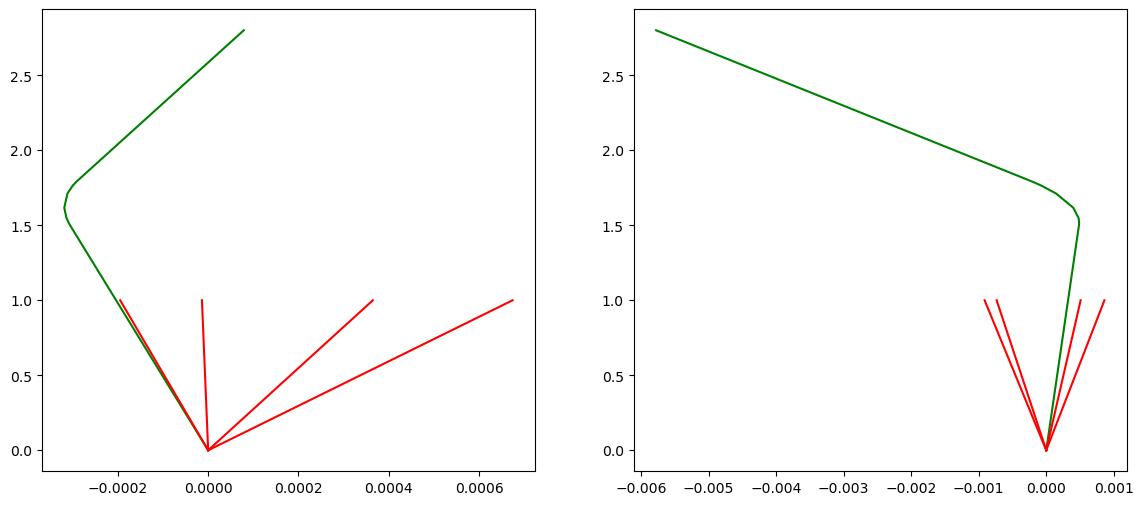

In [4]:
# Plot all trajectories
fig = figure(figsize=(14, 6))
ax_xz = fig.add_subplot(1, 2, 1)
ax_yz = fig.add_subplot(1, 2, 2)
success = collect_success_attribute(outputfile)
trajectories = collect_trajectories(outputfile)
for (s, traj) in zip(success, trajectories)
    x = traj[2, :]
    y = traj[3, :]
    z = traj[4, :]
    c = s ? "g" : "r"
    ax_xz.plot(x, z, c)
    ax_yz.plot(y, z, c)
end

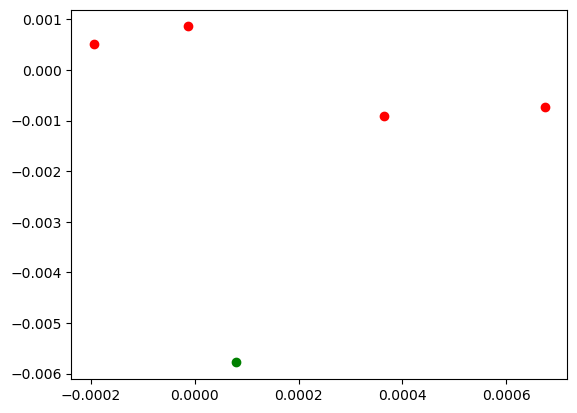

In [5]:
# x-y plot of end points
success = collect_success_attribute(outputfile)
p_success = collect_end_points(outputfile, success)
p_failed = collect_end_points(outputfile, .!success)

x_success = p_success[2, :]
y_success = p_success[3, :]
x_failed = p_failed[2, :]
y_failed = p_failed[3, :]
scatter(x_success, y_success, c="g")
scatter(x_failed, y_failed, c="r")
;